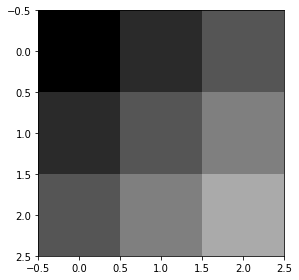

In [1]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

In [10]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    print(f"number_of_classes: {number_of_classes}")
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    print(f"img.shape: {img.shape}")
    expanded_img = np.expand_dims(input_img, axis=0)
    print(f"expanded_img.shape: {expanded_img.shape}")

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor,
                                        number_of_classes)
                
                print(f"upsample_filter_np.shape: {upsample_filter_np.shape}")
                #print(f"upsample_filter_np: {upsample_filter_np}")

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                        output_shape=[1, new_height, new_width, number_of_classes],
                        strides=[1, factor, factor, 1])

                final_result = sess.run(res,
                                feed_dict={upsample_filt_pl: upsample_filter_np,
                                           logits_pl: expanded_img})
    
    return final_result.squeeze()

upsampled_img_tf = upsample_tf(factor=3, input_img=img)
io.imshow(upsampled_img_tf)

number_of_classes: 3
img.shape: (3, 3, 3)
expanded_img.shape: (1, 3, 3, 3)
upsample_filter_np.shape: (5, 5, 3, 3)


InvalidArgumentError: Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 3, computed = 2
	 [[Node: conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 3, 3, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose/output_shape, _arg_Placeholder_0_0, _arg_Placeholder_1_0_1)]]

Caused by op 'conv2d_transpose', defined at:
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-b1880c8732bf>", line 83, in <module>
    upsampled_img_tf = upsample_tf(factor=3, input_img=img)
  File "<ipython-input-10-b1880c8732bf>", line 75, in upsample_tf
    strides=[1, factor, factor, 1])
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_ops.py", line 1048, in conv2d_transpose
    name=name)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 486, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/jfaath/dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 3, computed = 2
	 [[Node: conv2d_transpose = Conv2DBackpropInput[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 3, 3, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_transpose/output_shape, _arg_Placeholder_0_0, _arg_Placeholder_1_0_1)]]


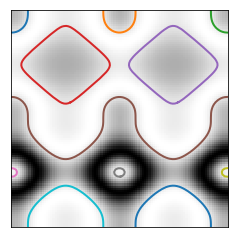

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    #print(f"len(contour): {len(contour)}")
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

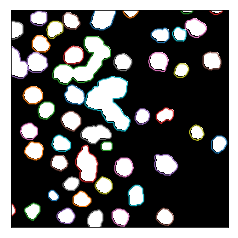

In [1]:
from skimage import measure
from PIL import Image
import numpy as np
import  matplotlib.pyplot as plt

i = Image.open('../jeff.png')
ia = np.asarray(i)

c = measure.find_contours(ia, 0.5)

fig, ax = plt.subplots()
ax.imshow(ia, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(c):
    #print(f"len(contour): {len(contour)}")
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [21]:
from PIL import ImageDraw

blank_imga = np.zeros(ia.shape)
blank_img = Image.fromarray(blank_imga)

#draw = ImageDraw.Draw(blank_img)

#print(len(c[15]))
#for n, contour in enumerate(c):
#draw.polygon(c[15], fill=128, outline=255)

fig2, ax2 = plt.subplots()
ax2.imshow(blank_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(c):
    #print(f"len(contour): {len(contour)}")
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax2.axis('image')
ax2.set_xticks([])
ax2.set_yticks([])
#plt.show()
fig2.savefig('../fig.png', pad_inches=0.0, bbox_inches='tight')

In [2]:
from skimage.morphology import label



In [23]:
import skimage

def drawShape(img, coordinates, color):
    # In order to draw our line in red
    img = skimage.color.gray2rgb(img)

    # Make sure the coordinates are expressed as integers
    coordinates = coordinates.astype(int)

    img[coordinates[:, 0], coordinates[:, 1]] = color

    return img

blank_imga = np.zeros(ia.shape, dtype=np.uint8)
blank_img = Image.fromarray(blank_imga)

print(f"ia shape and dtype: {ia.shape}, {ia.dtype}")
print(f"blank_imga shape and dtype: {blank_imga.shape}, {blank_imga.dtype}")

iac = blank_imga
for contour in c:
    iac = drawShape(iac, contour, [255, 0, 0]) 

iaci = Image.fromarray(iac)
iaci.save('../con.png')


ia shape and dtype: (256, 256), uint8
blank_imga shape and dtype: (256, 256), uint8


In [25]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

min = -5.
max = 5.

logits = np.random.rand(3,3) * (max-min) + min
print(logits)
logits = tf.constant(logits)

y = np.random.randint(0,2,(3,3)) * 1.
print(y)

sig = tf.nn.sigmoid(logits)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
mloss = tf.reduce_mean(loss)
mloss2 = tf.losses.sigmoid_cross_entropy(y, logits)
s, l, m, m2 = sess.run([sig, loss, mloss, mloss2])
print("sigmoid:")
print(s)
print("loss:")
print(l)
print("mean loss:")
print(m)
print("mean loss 2:")
print(m2)

[[ 4.50387124  1.25534065  2.3757101 ]
 [-3.40676001 -4.05638553  1.33541155]
 [ 1.8178813  -2.42242193 -4.60212993]]
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]
sigmoid:
[[ 0.98905504  0.77822298  0.91495623]
 [ 0.03208486  0.01701689  0.79173436]
 [ 0.86031171  0.08147881  0.00993084]]
loss:
[[ 4.51487653  0.25074218  2.46458916]
 [ 0.03261087  0.01716334  0.23352935]
 [ 1.9683418   0.08499031  0.00998048]]
mean loss:
1.06409155808
mean loss 2:
1.06409144402


In [35]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

min = -5.
max = 5.

logits = np.random.rand(3,3) * (max-min) + min
print(logits)
logits = tf.constant(logits)

y = np.random.randint(0,2,(3,3)) * 1.
print(y)

# Weights test
w = np.zeros((3,3))
w[y==1] = 4.
w[y==0] = 1.
print(w)
w = tf.constant(w)

sig = tf.nn.sigmoid(logits)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
mloss = tf.reduce_mean(loss)

loss_w = tf.multiply(loss, w)
mloss_w = tf.reduce_mean(loss_w)

mloss2 = tf.losses.sigmoid_cross_entropy(y, logits, weights=w)
s, l, lw, m, mw, m2 = sess.run([sig, loss, loss_w, mloss, mloss_w, mloss2])
print("sigmoid:")
print(s)
print("loss:")
print(l)
print("weighted loss:")
print(lw)
print("mean loss:")
print(m)
print("weighted mean loss:")
print(mw)
print("mean loss 2 (weighted):")
print(m2)

# TODO: test the weighted loss with batches. ie. If I output (batch_size, 256, 256) does the weight matrix need to
# be that size (a la per sample weights) or can it be (1, 256, 256) and broadcast to each sample correctly.

[[ 4.96249779  1.27312992  1.15699435]
 [-4.05554978  1.94146285  0.33391071]
 [ 3.47827527  2.09436719 -2.12180623]]
[[ 0.  1.  1.]
 [ 0.  0.  1.]
 [ 1.  1.  0.]]
[[ 1.  4.  4.]
 [ 1.  1.  4.]
 [ 4.  4.  1.]]
sigmoid:
[[ 0.99305316  0.78127807  0.76078614]
 [ 0.01703088  0.87451277  0.58271061]
 [ 0.97006327  0.89035449  0.10699537]]
loss:
[[ 4.96946887  0.24682415  0.27340298]
 [ 0.01717757  2.07555124  0.5400646 ]
 [ 0.03039398  0.11613559  0.11316351]]
weighted loss:
[[ 4.96946887  0.98729661  1.09361192]
 [ 0.01717757  2.07555124  2.1602584 ]
 [ 0.12157592  0.46454236  0.11316351]]
mean loss:
0.931353610418
weighted mean loss:
1.33362737785
mean loss 2 (weighted):
1.33362734318
